# MSc Data Science Dissertation Code

### Reece Ward - 261602

This Jupyter Notebook includes all the code used to complete the project. Please refer to the project report for my reasoning and discussion of each section.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
pd.set_option('mode.chained_assignment', None)
rndseed = 111

## The Dataset

## Loading, Cleaning, and Preprocessing Data

In [2]:
# Load each season data into seperate dataframe
epl_21_22 = pd.read_csv("EPL_21_22.csv")
epl_22_23 = pd.read_csv("EPL_22_23.csv")

# Combine seasons into one dataframe
epl_df = pd.concat([epl_21_22, epl_22_23])
epl_df = epl_df.reset_index(drop=True)

# Convert date strings to date
epl_df['Date'] = pd.to_datetime(epl_df['Date'], format='%d/%m/%Y')
epl_df

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,2021-08-13,20:00,Brentford,Arsenal,2,0,H,1,0,...,1.62,0.50,1.75,2.05,1.81,2.13,2.05,2.17,1.80,2.09
1,E0,2021-08-14,12:30,Man United,Leeds,5,1,H,1,0,...,2.25,-1.00,2.05,1.75,2.17,1.77,2.19,1.93,2.10,1.79
2,E0,2021-08-14,15:00,Burnley,Brighton,1,2,A,1,0,...,1.62,0.25,1.79,2.15,1.81,2.14,1.82,2.19,1.79,2.12
3,E0,2021-08-14,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,1.94,-1.50,2.05,1.75,2.12,1.81,2.16,1.93,2.06,1.82
4,E0,2021-08-14,15:00,Everton,Southampton,3,1,H,0,1,...,1.67,-0.50,2.05,1.88,2.05,1.88,2.08,1.90,2.03,1.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,E0,2023-05-28,16:30,Everton,Bournemouth,1,0,H,0,0,...,2.14,-1.00,2.02,1.77,2.10,1.81,2.17,1.92,2.03,1.83
756,E0,2023-05-28,16:30,Leeds,Tottenham,1,4,A,0,1,...,2.50,0.25,1.84,2.06,1.83,2.10,1.90,2.14,1.81,2.06
757,E0,2023-05-28,16:30,Leicester,West Ham,2,1,H,1,0,...,2.51,-0.25,1.75,2.05,1.85,2.06,1.90,2.16,1.82,2.04
758,E0,2023-05-28,16:30,Man United,Fulham,2,1,H,1,1,...,2.95,-1.25,1.98,1.92,1.98,1.93,2.07,1.98,1.97,1.89


### Missing Data

In [3]:
# Check for missing values in each column
missing_values = epl_df.isnull().sum()

# Filter the columns with missing data (where missing_values is greater than 0)
columns_with_missing_data = missing_values[missing_values > 0]

# Print the number of missing values in each column that has missing data
print("Number of missing values in columns with missing data:")
print(columns_with_missing_data)

Number of missing values in columns with missing data:
B365>2.5    1
B365<2.5    1
P>2.5       1
P<2.5       1
IWCH        3
IWCD        3
IWCA        3
PC>2.5      1
PC<2.5      1
B365CAHH    1
B365CAHA    1
dtype: int64


### Remove unnecessary columns

In [4]:
# Create a new dataframe with the selected columns
bookmaker_columns = ['Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTR', 'B365H', 'B365D', 'B365A', 'WHH', 'WHD', 'WHA']
bookmaker_df = epl_df[bookmaker_columns].copy()

# Create new columns for predictions
bookmaker_df.insert(8, 'B365_Pred', bookmaker_df[['B365H', 'B365D', 'B365A']].idxmin(axis=1).str[-1])
bookmaker_df.insert(12, 'WH_Pred', bookmaker_df[['WHH', 'WHD', 'WHA']].idxmin(axis=1).str[-1])

# Remove bookmaker odds columns from main dataframe
epl_df = epl_df.iloc[:, 1:24]

# Rename columns
column_mapping = {
    'HomeTeam': 'Home_Team', 'AwayTeam': 'Away_Team', 'FTHG': 'FT_HomeGoals', 'FTAG': 'FT_AwayGoals', 'FTR': 'FT_Result',
    'HTHG': 'HT_HomeGoals', 'HTAG': 'HT_AwayGoals', 'HTR': 'HT_Result', 'HS': 'H_Shots', 'AS': 'A_Shots',
    'HST': 'H_ShotsOnTarget', 'AST': 'A_ShotsOnTarget', 'HF': 'H_Fouls', 'AF': 'A_Fouls', 'HC': 'H_Corners',
    'AC': 'A_Corners', 'HY': 'H_YellowCards', 'AY': 'A_YellowCards', 'HR': 'H_RedCards', 'AR': 'A_RedCards'
}

epl_df = epl_df.rename(columns=column_mapping)

### Creating new features

In [5]:
# Function to calculate team season totals for a given match statistic and add it to the DataFrame
def calculate_total(df, home_col, away_col):
    # Define the column names for home and away season totals
    h_col1, h_col2 = 'Season_' + home_col, 'Season_' + home_col + "_Conceded"
    a_col1, a_col2 = 'Season_' + away_col, 'Season_' + away_col + "_Conceded"
    
    # Initialize the dictionaries that will hold the season totals
    season_total, season_total_conceded = {}, {}
    
    # Nested function to update season total and season total conceded for a team, returning the updated values
    def update_totals(team, team1col, team2col, season_total, season_total_conceded, row):
        # Get current season totals for each team
        team_total = season_total.get(team, 0)
        team_total_conceded = season_total_conceded.get(team, 0)
        
        # Update season total for each team
        season_total[team] = team_total + row[team1col]
        season_total_conceded[team] = team_total_conceded + row[team2col]
        return np.round(team_total), np.round(team_total_conceded)

    # Calculate and set each team's season totals
    for index, row in df.iterrows():
        df.at[index, h_col1], df.at[index, h_col2] = update_totals(row['Home_Team'], home_col, away_col, season_total, season_total_conceded, row)
        df.at[index, a_col1], df.at[index, a_col2] = update_totals(row['Away_Team'], away_col, home_col, season_total, season_total_conceded, row)
        
    return df

# Function to calculate team form totals for a given match statistic and add it to the DataFrame
def calculate_form(df, home_col, away_col, num_games):
    # Define the column names for home and away form totals
    h_col1, h_col2 = 'Form_' + home_col, 'Form_' + home_col + "_Conceded"
    a_col1, a_col2 = 'Form_' + away_col, 'Form_' + away_col + "_Conceded"

    # Nested function to calculate average values for a given team
    def calculate_avg(team, team1col, team2col, matches):
        team_total, team_conceded = 0, 0
        for _, row in matches.iterrows():
            # Update total and conceded goals depending on whether the team was playing home or away
            if team == row['Home_Team']:
                team_total += row[team1col]
                team_conceded += row[team2col]
            else:
                team_total += row[team2col]
                team_conceded += row[team1col]
                
        # Calculate average goals and conceded goals, or NaN if no matches were found (start of each season)
        if not matches.empty:
            avg_total = np.round(team_total / len(matches), 2) 
            avg_conceded = np.round(team_conceded / len(matches), 2)
        else:
            avg_total = np.nan
            avg_conceded = np.nan
        return avg_total, avg_conceded

    # Calculate form values for all matches in the dataframe
    for index, row in df.iterrows():
        home_team, away_team = row['Home_Team'], row['Away_Team']
        # Get the last num_games matches of home and away teams
        home_matches = df[(df.index < index) & ((df['Home_Team'] == home_team) | (df['Away_Team'] == home_team))].tail(num_games)
        away_matches = df[(df.index < index) & ((df['Home_Team'] == away_team) | (df['Away_Team'] == away_team))].tail(num_games)

        # Calculate average goals and conceded goals for home and away teams, and store them in the dataframe
        df.at[index, h_col1], df.at[index, h_col2] = calculate_avg(home_team, home_col, away_col, home_matches)
        df.at[index, a_col2], df.at[index, a_col1] = calculate_avg(away_team, away_col, home_col, away_matches)
        
    return df

In [9]:
# Function to calculate teams season points and add it to the DataFrame
def calculate_total_points(df):
    # Define the new columns for home and away season points totals
    df['Season_H_Points'] = np.nan
    df['Season_A_Points'] = np.nan
    
    # Track the season points for each team
    season_points = {}
    
    # Iterate through each row (match) in the datafrane
    for index, row in df.iterrows():
        home_team = row['Home_Team']
        away_team = row['Away_Team']
        
        # Get teams current points total
        home_seasonpt = season_points.get(home_team, 0)
        away_seasonpt = season_points.get(away_team, 0)
        
        # Store points total into column
        df.loc[index, 'Season_H_Points'] = home_seasonpt
        df.loc[index, 'Season_A_Points'] = away_seasonpt
        
        # Update points total after current match (used in next match entry)
        if row['FT_Result'] == 'H':  # Home team wins
            home_seasonpt += 3
        elif row['FT_Result'] == 'A':  # Away team wins
            away_seasonpt += 3
        else:  # Draw
            home_seasonpt += 1
            away_seasonpt += 1
            
        # Update the cumulative points dictionary 
        season_points[home_team] = home_seasonpt
        season_points[away_team] = away_seasonpt
    return df

# Function to calculate teams form points and add it to the DataFrame
def calculate_form_points(df, num_games):
    # Add new columns for Form points of Home and Away Teams
    df['Form_H_Points'] = np.nan
    df['Form_A_Points'] = np.nan

    # Nested function to calculate the points earned in recent games for a team
    def calculate_points(team, matches):
        points = 0
        for _, row in matches.iterrows():
            if row['FT_Result'] == "D": # Draw: 1 point
                points += 1
            elif (team == row['Home_Team']) & (row['FT_Result'] == "H"): # Win: 3 points
                points += 3
            elif (team == row['Away_Team']) & (row['FT_Result'] == "A"): # Win: 3 points
                points += 3
        return points
    
    # Iterate through each row (match) in the dataframe
    for index, row in df.iterrows():
        home_team = row['Home_Team']
        away_team = row['Away_Team']
        
        # Get recent matches for home and away teams
        home_matches = df[(df.index < index) & ((df['Home_Team'] == home_team) | (df['Away_Team'] == home_team))].tail(num_games)
        away_matches = df[(df.index < index) & ((df['Home_Team'] == away_team) | (df['Away_Team'] == away_team))].tail(num_games)
        
        # Calculate and store the form points values in the new columns
        df.loc[index, 'Form_H_Points'] = calculate_points(home_team, home_matches)
        df.loc[index, 'Form_A_Points'] = calculate_points(away_team, away_matches)
        
    return df

In [6]:
# Separate the dataframes by season and calculate total and form statistics
season1_df = epl_df[epl_df['Date'] < '2022-07-01']
season2_df = epl_df[epl_df['Date'] >= '2022-07-01']

In [7]:
# Match statistic columns for above features
columns = [('FT_HomeGoals', 'FT_AwayGoals'), 
           ('H_Shots', 'A_Shots'), 
           ('H_ShotsOnTarget', 'A_ShotsOnTarget'),
           ('H_Corners', 'A_Corners'),
           ('H_Fouls', 'A_Fouls')]

# Apply calculate_total and calculate_form functions for each pair of columns
for home_col, away_col in columns:
    for df in [season1_df, season2_df]:
        df = calculate_total(df, home_col, away_col)
        df = calculate_form(df, home_col, away_col, 3)

In [10]:
# Calculate total and form points for each season
season1_df = calculate_total_points(season1_df)
season2_df = calculate_total_points(season2_df)
season1_df = calculate_form_points(season1_df, 3)
season2_df = calculate_form_points(season2_df, 3)

# Combine dataframes
epl_df = pd.concat([season1_df, season2_df], ignore_index=True)

# Rename Foul columns to avoid confusion terminology
epl_df = epl_df.rename(columns={"Form_H_Fouls_Conceded": "Form_H_Fouls_Received", "Form_H_Fouls": "Form_H_Fouls_Conceded", "Form_A_Fouls_Conceded": "Form_A_Fouls_Received", "Form_A_Fouls": "Form_A_Fouls_Conceded", "Season_H_Fouls_Conceded": "Season_H_Fouls_Received", "Season_H_Fouls": "Season_H_Fouls_Conceded", "Season_A_Fouls_Conceded": "Season_A_Fouls_Received", "Season_A_Fouls": "Season_A_Fouls_Conceded"})
epl_df

,Date,Time,Home_Team,Away_Team,FT_HomeGoals,FT_AwayGoals,FT_Result,HT_HomeGoals,HT_AwayGoals,HT_Result,...,Season_A_Fouls_Conceded,Season_A_Fouls_Received,Form_H_Fouls_Conceded,Form_H_Fouls_Received,Form_A_Fouls_Received,Form_A_Fouls_Conceded,Season_H_Points,Season_A_Points,Form_H_Points,Form_A_Points
0,2021-08-13,20:00,Brentford,Arsenal,2,0,H,1,0,H,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,2021-08-14,12:30,Man United,Leeds,5,1,H,1,0,H,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,2021-08-14,15:00,Burnley,Brighton,1,2,A,1,0,H,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,2021-08-14,15:00,Chelsea,Crystal Palace,3,0,H,2,0,H,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
4,2021-08-14,15:00,Everton,Southampton,3,1,H,0,1,A,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2023-05-28,16:30,Everton,Bournemouth,1,0,H,0,0,D,...,379.0,364.0,11.67,11.00,7.67,9.00,33.0,39.0,4.0,0.0
756,2023-05-28,16:30,Leeds,Tottenham,1,4,A,0,1,A,...,418.0,373.0,14.33,7.67,10.67,13.33,31.0,57.0,1.0,3.0
757,2023-05-28,16:30,Leicester,West Ham,2,1,H,1,0,H,...,351.0,319.0,10.33,13.00,8.33,5.00,31.0,40.0,1.0,6.0
758,2023-05-28,16:30,Man United,Fulham,2,1,H,1,1,D,...,401.0,405.0,9.33,7.00,14.67,12.67,72.0,52.0,9.0,7.0


## Data Analysis

###  Match Results

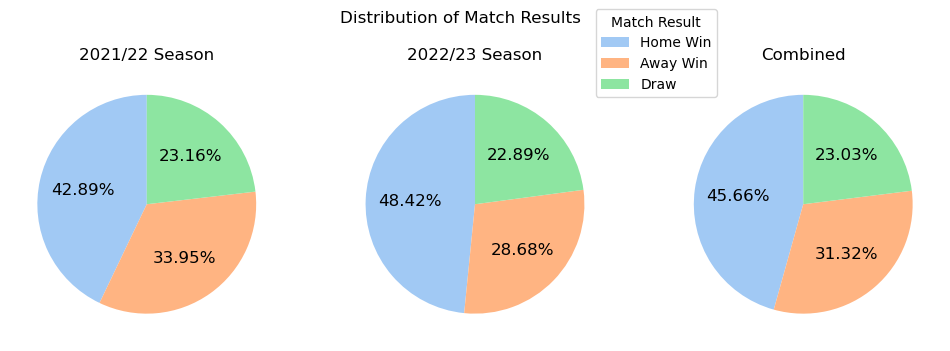

In [11]:
# Calculate the count of each match result for each season
season1_result_counts = season1_df['FT_Result'].value_counts()
season2_result_counts = season2_df['FT_Result'].value_counts()
combined_result_counts = epl_df['FT_Result'].value_counts()

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].pie(season1_result_counts, colors=sns.color_palette('pastel'), autopct='%1.2f%%', startangle=90, textprops={'fontsize': 12})
axes[0].set_title('2021/22 Season')
axes[1].pie(season2_result_counts, colors=sns.color_palette('pastel'), autopct='%1.2f%%', startangle=90, textprops={'fontsize': 12})
axes[1].set_title('2022/23 Season')
axes[2].pie(combined_result_counts, colors=sns.color_palette('pastel'), autopct='%1.2f%%', startangle=90, textprops={'fontsize': 12})
axes[2].set_title('Combined')

fig.suptitle("Distribution of Match Results")
fig.legend(['Home Win', 'Away Win', 'Draw'], loc="upper right", title="Match Result", bbox_to_anchor=(.72, 1))
plt.show()

In [12]:
# Function to calculate win percent of each team, overall, home, and away
def calculate_win_percentages(df):
    teams = df['Home_Team'].unique()
    teams.sort()  # Sort teams alphabetically
    win_percentages, home_win_percentages, away_win_percentages, diff_percentages = [], [], [], []

    for team in teams:
        total_matches = len(df[(df['Home_Team'] == team) | (df['Away_Team'] == team)])
        home_matches = len(df[df['Home_Team'] == team])
        away_matches = total_matches - home_matches

        total_wins = len(df[(df['Home_Team'] == team) & (df['FT_Result'] == 'H')]) + len(df[(df['Away_Team'] == team) & (df['FT_Result'] == 'A')])
        home_wins = len(df[(df['Home_Team'] == team) & (df['FT_Result'] == 'H')])
        away_wins = total_wins - home_wins

        win_percentages.append(round((total_wins / total_matches) * 100, 2))
        home_win_percentages.append(round((home_wins / home_matches) * 100, 2))
        away_win_percentages.append(round((away_wins / away_matches) * 100, 2))
        diff_percentages.append(round((home_wins / home_matches) * 100, 2) - round((away_wins / away_matches) * 100, 2))

    return pd.DataFrame({'Team': teams, 'Win_Percentage': win_percentages, 'Home_Win_Percentage': home_win_percentages, 'Away_Win_Percentage': away_win_percentages, 'Difference_Percentage': diff_percentages})

win_percentages_df = calculate_win_percentages(epl_df)
win_percentages_df = win_percentages_df.sort_values(by='Win_Percentage', ascending=False)
win_percentages_df

,Team,Win_Percentage,Home_Win_Percentage,Away_Win_Percentage,Difference_Percentage
13,Man City,75.00,84.21,65.79,18.42
0,Arsenal,63.16,71.05,55.26,15.79
12,Liverpool,61.84,73.68,50.00,23.68
19,Tottenham,52.63,65.79,39.47,26.32
14,Man United,51.32,65.79,36.84,28.95
6,Chelsea,42.11,39.47,44.74,-5.27
15,Newcastle,42.11,50.00,34.21,15.79
1,Aston Villa,40.79,47.37,34.21,13.16
4,Brighton,39.47,39.47,39.47,0.00
9,Fulham,39.47,42.11,36.84,5.27


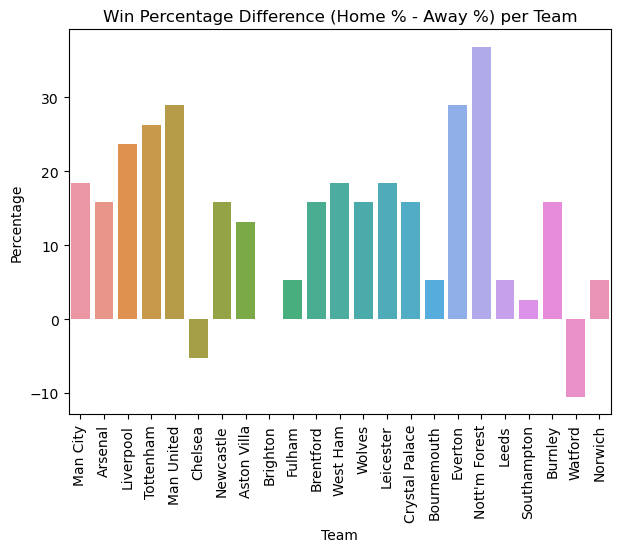

In [13]:
# Plot Difference_Percentage graph
plt.figure(figsize=(7, 5))
sns.barplot(x='Team', y='Difference_Percentage', data=win_percentages_df)
plt.xticks(rotation=90)
plt.xlabel('Team')
plt.ylabel('Percentage')
plt.title('Win Percentage Difference (Home % - Away %) per Team')
plt.show()

###  Goals

In [14]:
def get_season_totals(df, home_col, away_col, hometotal_f, hometotal_a, awaytotal_f, awaytotal_a, description1, description2, dates):
    total_df = pd.DataFrame({"Team": sorted(set(df['Home_Team']).union(df['Away_Team']))})
    
    for i in range(0, len(dates)): # Loop for each season
        stats_for, stats_conceded = {}, {}
        final_round = epl_df[(epl_df['Date'] == dates[i])]
        
        for e, row in final_round.iterrows(): # Loop each final round match 
            stats_for[row['Home_Team']] = row[hometotal_f] + row[home_col] # Home team stat for
            stats_conceded[row['Home_Team']] = row[hometotal_a] + row[away_col] # Home team stat conceded
                
            stats_for[row['Away_Team']] = row[awaytotal_f] + row[away_col] # Away team stat for
            stats_conceded[row['Away_Team']] = row[awaytotal_a] + row[home_col] # Away team stat conceded
            
        # Update total_df with the calculated values for each team
        for team in total_df['Team']:
            total_df.loc[total_df['Team'] == team, f'S{i+1}_{description1}'] = stats_for.get(team, "X")
            total_df.loc[total_df['Team'] == team, f'S{i+1}_{description2}'] = stats_conceded.get(team, "X")
        
    return total_df

In [15]:
total_goals = get_season_totals(epl_df, 'FT_HomeGoals', 'FT_AwayGoals', 'Season_FT_HomeGoals', 'Season_FT_HomeGoals_Conceded', "Season_FT_AwayGoals", "Season_FT_AwayGoals_Conceded", "Goals_Scored", "Goals_Conceded", ["2022-05-22", "2023-05-28"])
total_goals

,Team,S1_Goals_Scored,S1_Goals_Conceded,S2_Goals_Scored,S2_Goals_Conceded
0,Arsenal,61.0,48.0,88.0,43.0
1,Aston Villa,52.0,54.0,51.0,46.0
2,Bournemouth,X,X,37.0,71.0
3,Brentford,48.0,56.0,58.0,46.0
4,Brighton,42.0,44.0,72.0,53.0
5,Burnley,34.0,53.0,X,X
6,Chelsea,76.0,33.0,38.0,47.0
7,Crystal Palace,50.0,46.0,40.0,49.0
8,Everton,43.0,66.0,34.0,57.0
9,Fulham,X,X,55.0,53.0


In [16]:
# Function to retrieve and plot team form data for a given match statistic
def boxplot_team_form(df, home_col, away_col, ylabel, title, plot=True):
    stat_dict = {}
    teams = sorted(set(df['Home_Team']).union(df['Away_Team']))

    for index, row in df.iterrows():
        home_team = row['Home_Team']
        away_team = row['Away_Team']
        home_stat = row[home_col]
        away_stat = row[away_col]

        # Update form stat for home team
        if home_team in stat_dict:
            stat_dict[home_team].append(home_stat)
        else:
            stat_dict[home_team] = [home_stat]

        # Update form stat for away team
        if away_team in stat_dict:
            stat_dict[away_team].append(away_stat)
        else:
            stat_dict[away_team] = [away_stat]

    # Fill empty data as some teams who were promoted/relegated have less data
    stat_dict = {team: values + [float('nan')] * (76 - len(values)) for team, values in stat_dict.items()}
    
    # Convert dictionary to DataFrame
    stat_df = pd.DataFrame(stat_dict)
    stat_df = stat_df.melt(var_name='Team', value_name=ylabel)
    stat_df['Team'] = pd.Categorical(stat_df['Team'], categories=teams, ordered=True)
    
    if plot:
        # Create the boxplot using seaborn
        plt.figure(figsize=(11, 6))
        sns.boxplot(x='Team', y=ylabel, data=stat_df)
        plt.xticks(rotation=90)
        plt.title(title)
        plt.xlabel('Team')
        plt.ylabel(ylabel)
        plt.show()
    
    return stat_df

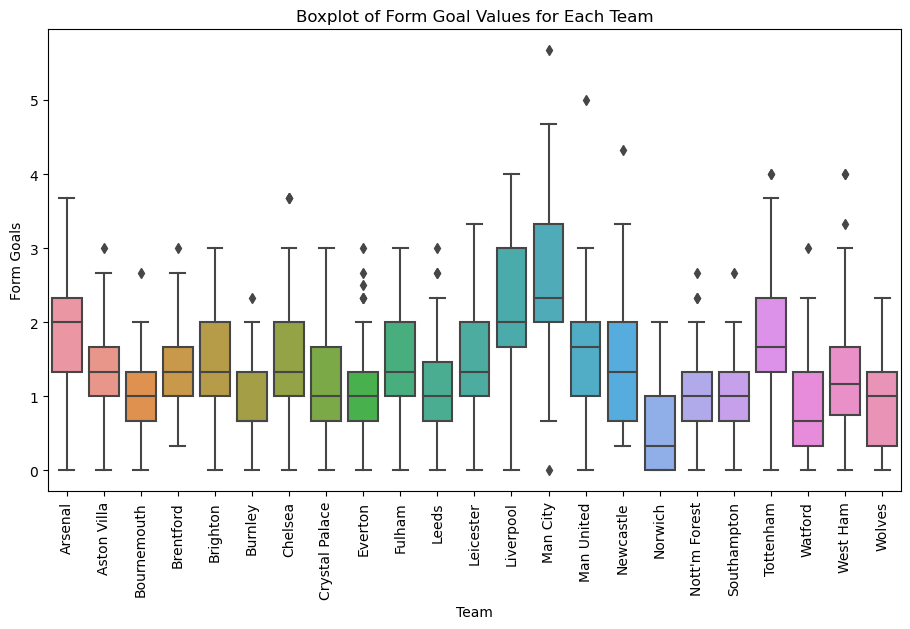

In [17]:
form_goals_df = boxplot_team_form(epl_df, 'Form_FT_HomeGoals', 'Form_FT_AwayGoals', 
                                              'Form Goals', 'Boxplot of Form Goal Values for Each Team')

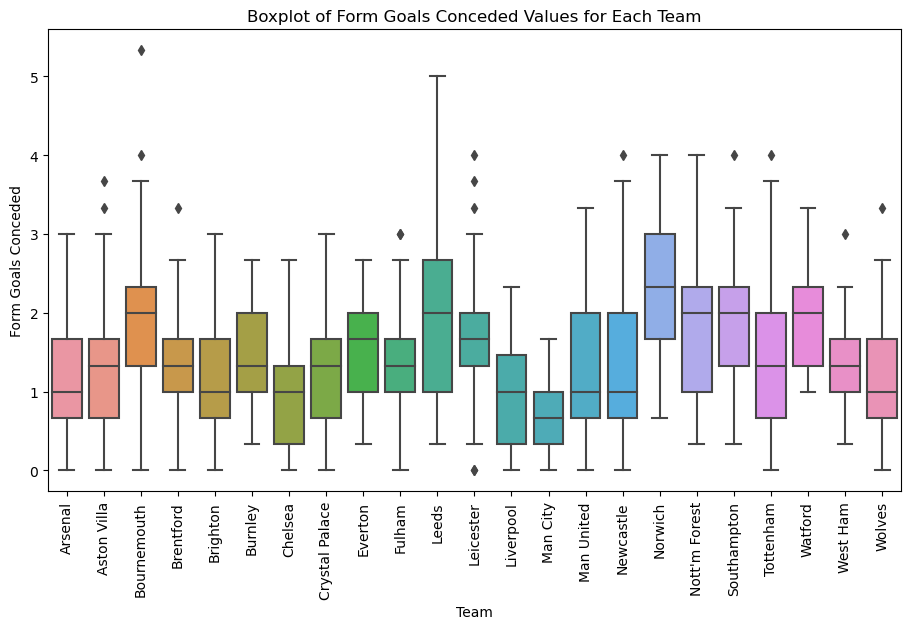

In [18]:
form_goals_c_df = boxplot_team_form(epl_df, 'Form_FT_HomeGoals_Conceded', 'Form_FT_AwayGoals_Conceded', 
                                              'Form Goals Conceded', 'Boxplot of Form Goals Conceded Values for Each Team')

In [19]:
# Function to compare form match statistics of winning, drawing, and losing teams
def compare_form(df, homecol, awaycol, xlabel, title):
    winner_form, draw_form, loser_form = [], [], []
    
    for i, row in df.iterrows():
        if row['FT_Result'] == "H":
            winner_form.append(row[homecol])
            loser_form.append(row[awaycol])
        elif row['FT_Result'] == "D":
            draw_form.append(row[homecol])
            draw_form.append(row[awaycol])
        elif row['FT_Result'] == "A":
            loser_form.append(row[homecol])
            winner_form.append(row[awaycol])

    # Fill empty data as drawing results have less data than other results
    draw_form += [None] * (len(winner_form) - len(draw_form))   
    form_df = pd.DataFrame({"Winning Team": winner_form, "Drawing Teams": draw_form, "Losing Team":loser_form})

    # Plot boxplot
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=form_df, orient="h", palette=["#6AC238", "#DDCC77", "#CC6677"])
    plt.ylabel('Result')
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()
    
    return form_df.describe().T

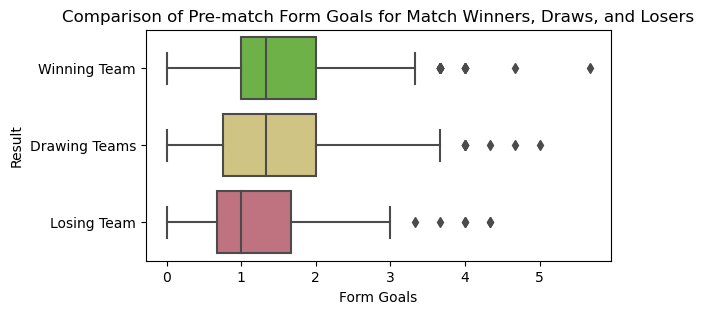

,count,mean,std,min,25%,50%,75%,max
Winning Team,567.0,1.569383,0.927058,0.0,1.0000,1.33,2.00,5.67
Drawing Teams,346.0,1.427659,0.881226,0.0,0.7525,1.33,2.00,5.00
Losing Team,567.0,1.242152,0.745773,0.0,0.6700,1.00,1.67,4.33


In [20]:
compare_form_goals = compare_form(epl_df, 'Form_FT_HomeGoals', 'Form_FT_AwayGoals', 'Form Goals', 
                                  'Comparison of Pre-match Form Goals for Match Winners, Draws, and Losers')
compare_form_goals

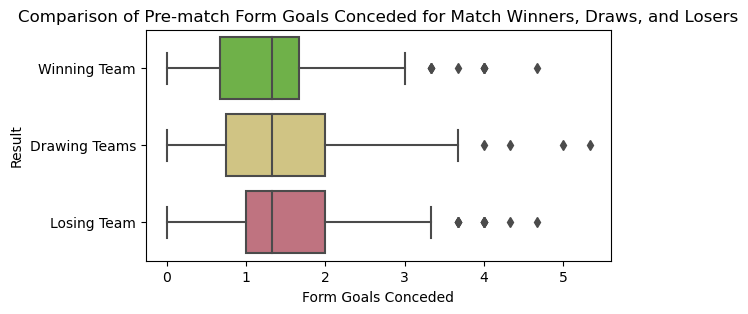

,count,mean,std,min,25%,50%,75%,max
Winning Team,567.0,1.279806,0.772629,0.0,0.6700,1.33,1.67,4.67
Drawing Teams,346.0,1.420491,0.875770,0.0,0.7525,1.33,2.00,5.33
Losing Team,567.0,1.527919,0.813609,0.0,1.0000,1.33,2.00,4.67


In [21]:
compare_form_goals_c = compare_form(epl_df, 'Form_FT_HomeGoals_Conceded', 'Form_FT_AwayGoals_Conceded', 'Form Goals Conceded', 
                                  'Comparison of Pre-match Form Goals Conceded for Match Winners, Draws, and Losers')
compare_form_goals_c

In [22]:
# Function to calculate percentage of winning team having a higher pre-match form value
def test_percent(df, homecol, awaycol):
    df = df.dropna() # Remove Week 1 matches that contain no form values
    total = 0
    
    for i, row in df.iterrows():
        if (row[homecol] > row[awaycol]) & (row['FT_Result'] == 'H') | (row[homecol] < row[awaycol]) & (row['FT_Result'] == 'A'):
            total += 1
    
    result = (total / len(df)) * 100
    return np.round(result, 3) 

In [23]:
x1 = test_percent(epl_df, 'Form_FT_HomeGoals', 'Form_FT_AwayGoals')
print(f'The team with the higher pre-match form goals scored won {x1}% of matches')
x2 = test_percent(epl_df, 'Season_FT_HomeGoals', 'Season_FT_AwayGoals')
print(f'The team with the higher pre-match season goals scored won {x2}% of matches')

percent_df = pd.DataFrame(columns=['Match Statistic', 'Form Win %', 'Season Win %'])
percent_df = pd.concat([percent_df, pd.DataFrame({'Match Statistic': 'Goals Scored', 'Form Win %': str(x1) + '%', 'Season Win %': str(x2) + '%'}, index=[0])], ignore_index=True)
percent_df

The team with the higher pre-match form goals scored won 40.0% of matches
The team with the higher pre-match season goals scored won 46.622% of matches


,Match Statistic,Form Win %,Season Win %
0,Goals Scored,40.0%,46.622%


###  Shots

In [24]:
total_shots = get_season_totals(epl_df, 'H_Shots', 'A_Shots', 'Season_H_Shots', 'Season_H_Shots_Conceded', "Season_A_Shots", "Season_A_Shots_Conceded", "Shots_Taken", "Shots_Conceded", ["2022-05-22", "2023-05-28"])
total_shots

,Team,S1_Shots_Taken,S1_Shots_Conceded,S2_Shots_Taken,S2_Shots_Conceded
0,Arsenal,588.0,425.0,593.0,341.0
1,Aston Villa,454.0,477.0,431.0,423.0
2,Bournemouth,X,X,355.0,626.0
3,Brentford,442.0,502.0,397.0,561.0
4,Brighton,490.0,476.0,612.0,388.0
5,Burnley,407.0,603.0,X,X
6,Chelsea,592.0,341.0,484.0,438.0
7,Crystal Palace,412.0,443.0,425.0,456.0
8,Everton,438.0,522.0,429.0,575.0
9,Fulham,X,X,429.0,505.0


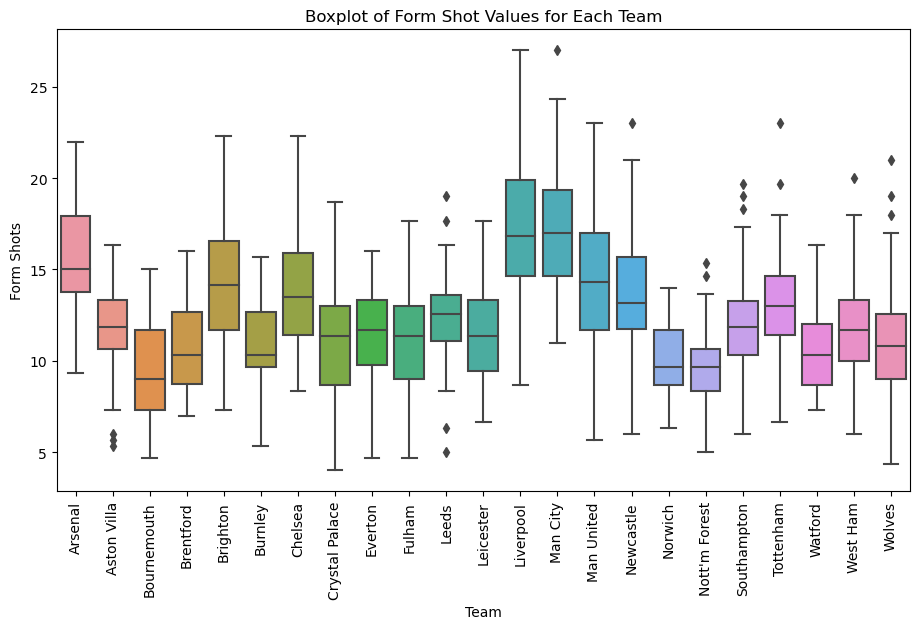

In [25]:
form_shots_df = boxplot_team_form(epl_df, 'Form_H_Shots', 'Form_A_Shots', 
                                              'Form Shots', 'Boxplot of Form Shot Values for Each Team')

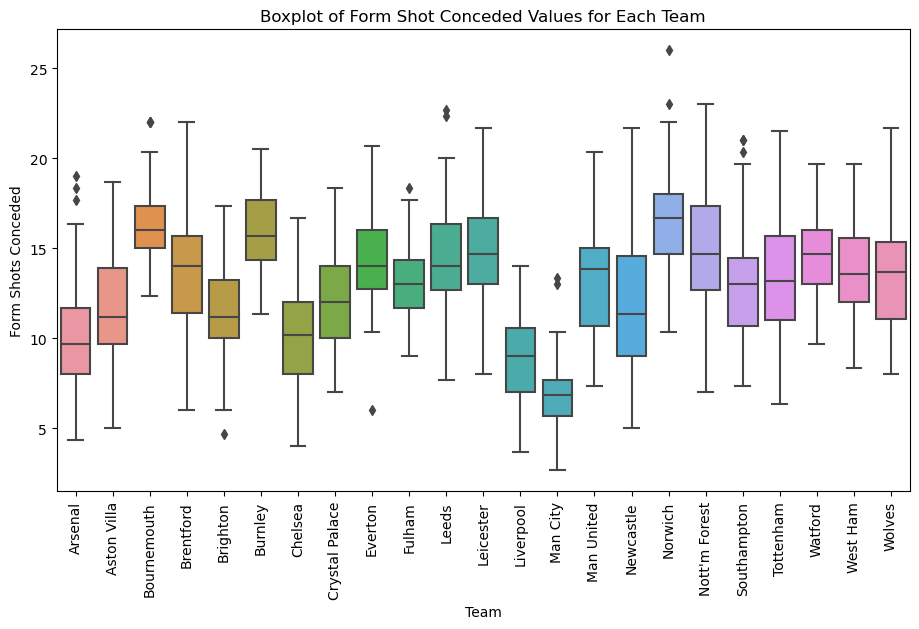

In [26]:
form_shots_c_df = boxplot_team_form(epl_df, 'Form_H_Shots_Conceded', 'Form_A_Shots_Conceded', 
                                              'Form Shots Conceded', 'Boxplot of Form Shot Conceded Values for Each Team')

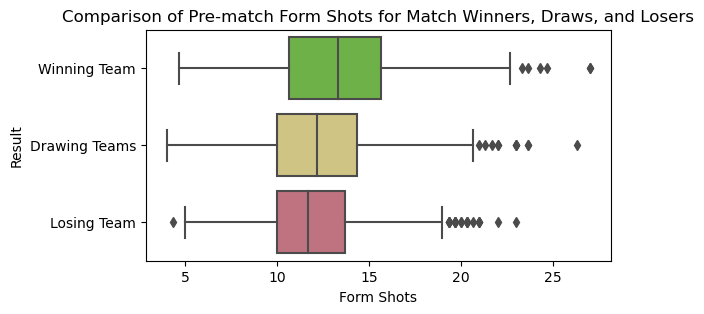

,count,mean,std,min,25%,50%,75%,max
Winning Team,567.0,13.466825,3.893906,4.67,10.67,13.330,15.67,27.00
Drawing Teams,346.0,12.418786,3.748665,4.00,10.00,12.165,14.33,26.33
Losing Team,567.0,12.035344,3.191583,4.33,10.00,11.670,13.67,23.00


In [27]:
compare_form_shots = compare_form(epl_df, 'Form_H_Shots', 'Form_A_Shots', 'Form Shots', 
                                  'Comparison of Pre-match Form Shots for Match Winners, Draws, and Losers')
compare_form_shots

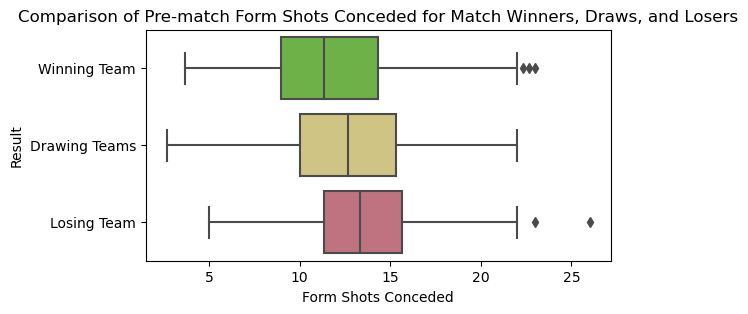

,count,mean,std,min,25%,50%,75%,max
Winning Team,567.0,11.746843,3.807844,3.67,9.00,11.33,14.33,23.0
Drawing Teams,346.0,12.735347,3.690258,2.67,10.00,12.67,15.33,22.0
Losing Team,567.0,13.528325,3.319184,5.00,11.33,13.33,15.67,26.0


In [28]:
compare_form_shots_c = compare_form(epl_df, 'Form_H_Shots_Conceded', 'Form_A_Shots_Conceded', 'Form Shots Conceded', 
                                  'Comparison of Pre-match Form Shots Conceded for Match Winners, Draws, and Losers')
compare_form_shots_c

In [29]:
x1 = test_percent(epl_df, 'Form_H_Shots', 'Form_A_Shots')
print(f'The team with the higher pre-match form shots taken won {x1}% of matches')
x2 = test_percent(epl_df, 'Season_H_Shots', 'Season_A_Shots')
print(f'The team with the higher pre-match season shots taken won {x2}% of matches')

percent_df = pd.concat([percent_df, pd.DataFrame({'Match Statistic': 'Shots Taken', 'Form Win %': str(x1) + '%', 'Season Win %': str(x2) + '%'}, index=[0])], ignore_index=True)
percent_df

The team with the higher pre-match form shots taken won 46.622% of matches
The team with the higher pre-match season shots taken won 50.811% of matches


,Match Statistic,Form Win %,Season Win %
0,Goals Scored,40.0%,46.622%
1,Shots Taken,46.622%,50.811%


###  Shots On Target

In [30]:
total_sot = get_season_totals(epl_df, 'H_ShotsOnTarget', 'A_ShotsOnTarget', "Season_H_ShotsOnTarget", "Season_H_ShotsOnTarget_Conceded", "Season_A_ShotsOnTarget", "Season_A_ShotsOnTarget_Conceded", "SOT_Taken", "SOT_Conceded", ["2022-05-22", "2023-05-28"])
total_sot

,Team,S1_SOT_Taken,S1_SOT_Conceded,S2_SOT_Taken,S2_SOT_Conceded
0,Arsenal,197.0,147.0,204.0,136.0
1,Aston Villa,162.0,157.0,151.0,159.0
2,Bournemouth,X,X,133.0,206.0
3,Brentford,154.0,183.0,162.0,205.0
4,Brighton,152.0,152.0,231.0,133.0
5,Burnley,125.0,187.0,X,X
6,Chelsea,211.0,119.0,158.0,168.0
7,Crystal Palace,147.0,146.0,136.0,162.0
8,Everton,138.0,190.0,152.0,193.0
9,Fulham,X,X,149.0,200.0


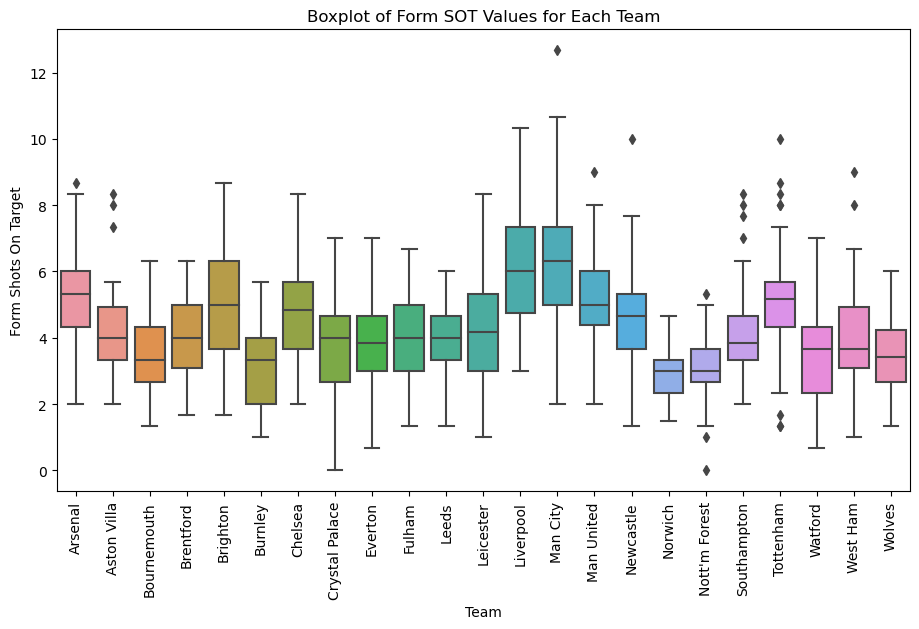

In [31]:
form_sot_df = boxplot_team_form(epl_df, 'Form_H_ShotsOnTarget', 'Form_A_ShotsOnTarget', 
                                              'Form Shots On Target', 'Boxplot of Form SOT Values for Each Team')

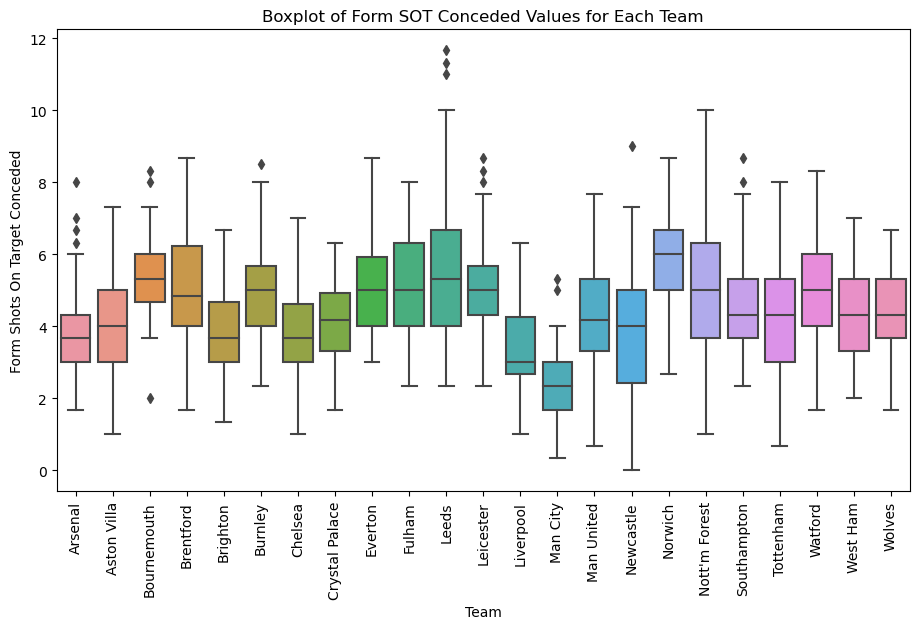

In [32]:
form_sot_c_df = boxplot_team_form(epl_df, 'Form_H_ShotsOnTarget_Conceded', 'Form_A_ShotsOnTarget_Conceded', 
                                              'Form Shots On Target Conceded', 'Boxplot of Form SOT Conceded Values for Each Team')

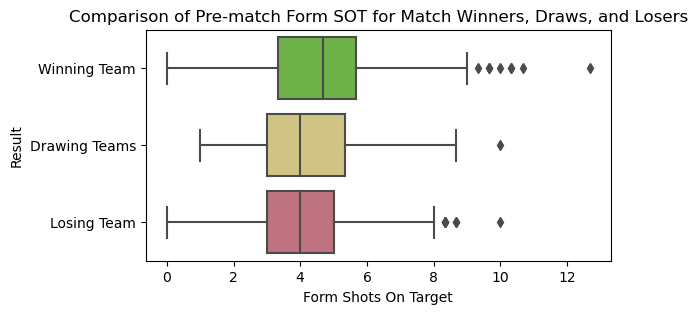

,count,mean,std,min,25%,50%,75%,max
Winning Team,567.0,4.705661,1.753377,0.0,3.33,4.67,5.67,12.67
Drawing Teams,346.0,4.336445,1.618066,1.0,3.00,4.00,5.33,10.00
Losing Team,567.0,4.092681,1.471086,0.0,3.00,4.00,5.00,10.00


In [33]:
compare_form_sot = compare_form(epl_df, 'Form_H_ShotsOnTarget', 'Form_A_ShotsOnTarget', 'Form Shots On Target', 
                                  'Comparison of Pre-match Form SOT for Match Winners, Draws, and Losers')
compare_form_sot

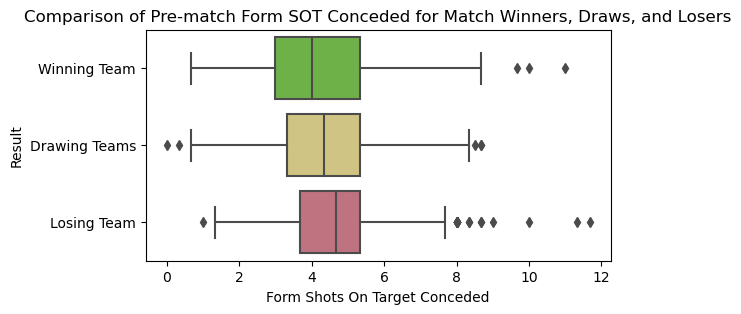

,count,mean,std,min,25%,50%,75%,max
Winning Team,567.0,4.097019,1.632905,0.67,3.00,4.00,5.33,11.00
Drawing Teams,346.0,4.398439,1.617950,0.00,3.33,4.33,5.33,8.67
Losing Team,567.0,4.650353,1.489731,1.00,3.67,4.67,5.33,11.67


In [34]:
compare_form_sot_c = compare_form(epl_df, 'Form_H_ShotsOnTarget_Conceded', 'Form_A_ShotsOnTarget_Conceded', 'Form Shots On Target Conceded', 
                                  'Comparison of Pre-match Form SOT Conceded for Match Winners, Draws, and Losers')
compare_form_sot_c

In [35]:
x1 = test_percent(epl_df, 'Form_H_ShotsOnTarget', 'Form_A_ShotsOnTarget')
print(f'The team with the higher pre-match form shots on target taken won {x1}% of matches')
x2 = test_percent(epl_df, 'Season_H_ShotsOnTarget', 'Season_A_ShotsOnTarget')
print(f'The team with the higher pre-match season shots on target taken won {x2}% of matches')

percent_df = pd.concat([percent_df, pd.DataFrame({'Match Statistic': 'Shots On Target Taken', 'Form Win %': str(x1) + '%', 'Season Win %': str(x2) + '%'}, index=[0])], ignore_index=True)
percent_df

The team with the higher pre-match form shots on target taken won 44.459% of matches
The team with the higher pre-match season shots on target taken won 49.73% of matches


,Match Statistic,Form Win %,Season Win %
0,Goals Scored,40.0%,46.622%
1,Shots Taken,46.622%,50.811%
2,Shots On Target Taken,44.459%,49.73%


###  Corners

In [36]:
total_corners = get_season_totals(epl_df, 'H_Corners', 'A_Corners', 'Season_H_Corners', 'Season_H_Corners_Conceded', "Season_A_Corners", "Season_A_Corners_Conceded", "Corners_Taken", "Corners_Conceded", ["2022-05-22", "2023-05-28"])
total_corners

,Team,S1_Corners_Taken,S1_Corners_Conceded,S2_Corners_Taken,S2_Corners_Conceded
0,Arsenal,209.0,176.0,223.0,141.0
1,Aston Villa,196.0,222.0,165.0,212.0
2,Bournemouth,X,X,144.0,272.0
3,Brentford,159.0,232.0,163.0,214.0
4,Brighton,202.0,212.0,233.0,136.0
5,Burnley,184.0,255.0,X,X
6,Chelsea,242.0,152.0,209.0,182.0
7,Crystal Palace,176.0,184.0,186.0,178.0
8,Everton,161.0,219.0,175.0,239.0
9,Fulham,X,X,185.0,204.0


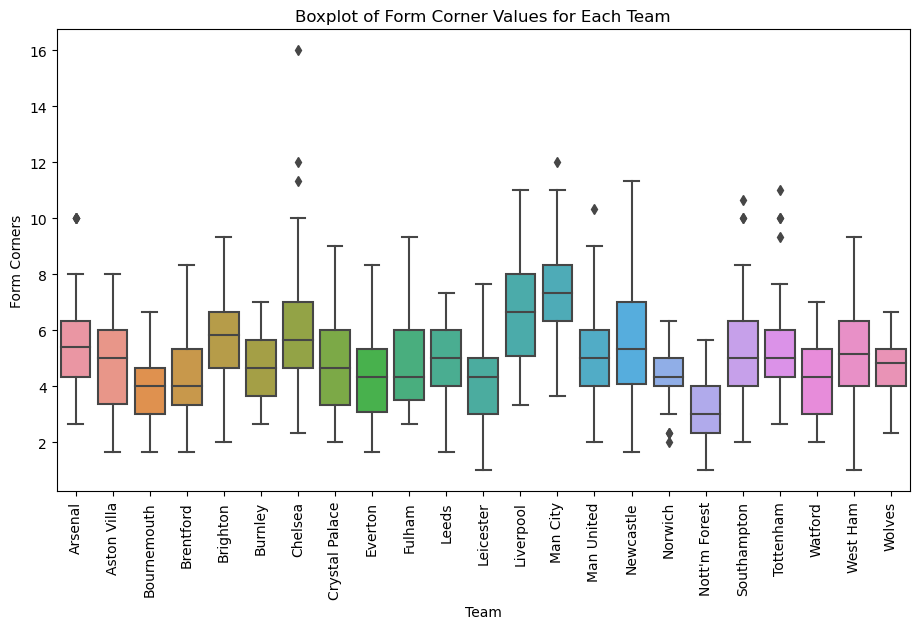

In [37]:
form_corners_df = boxplot_team_form(epl_df, 'Form_H_Corners', 'Form_A_Corners', 
                                              'Form Corners', 'Boxplot of Form Corner Values for Each Team')

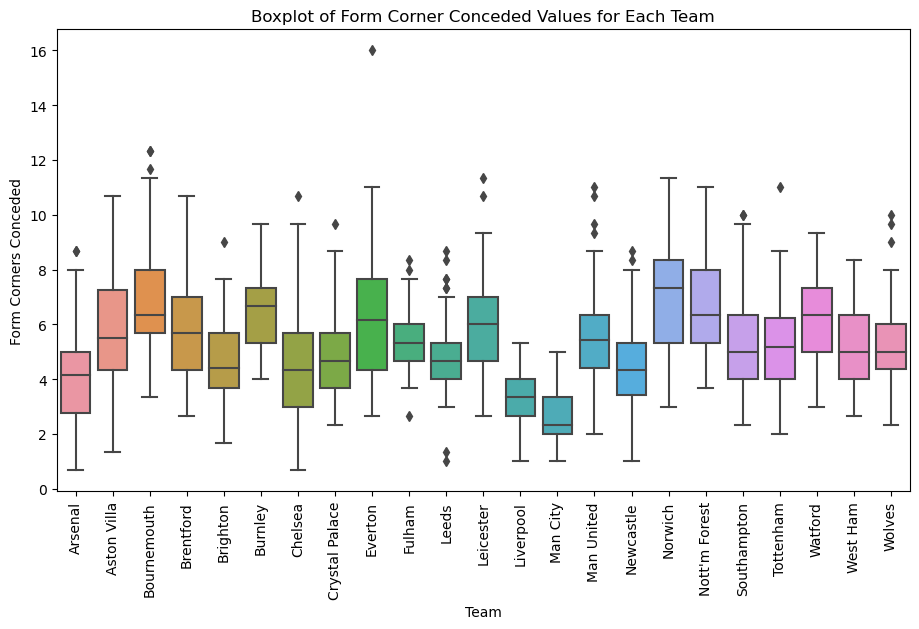

In [38]:
form_corners_c_df = boxplot_team_form(epl_df, 'Form_H_Corners_Conceded', 'Form_A_Corners_Conceded', 
                                              'Form Corners Conceded', 'Boxplot of Form Corner Conceded Values for Each Team')

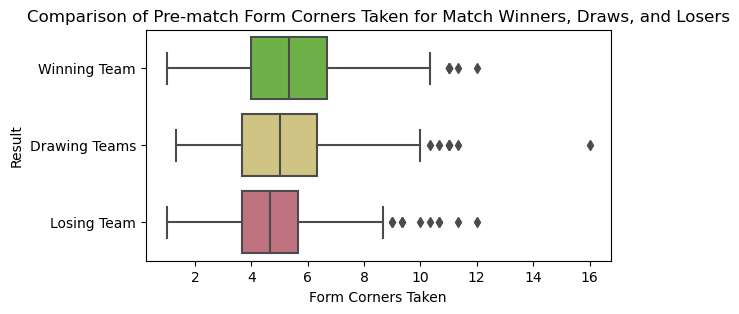

,count,mean,std,min,25%,50%,75%,max
Winning Team,567.0,5.480917,1.927814,1.00,4.00,5.33,6.67,12.0
Drawing Teams,346.0,5.110780,2.063871,1.33,3.67,5.00,6.33,16.0
Losing Team,567.0,4.840758,1.592636,1.00,3.67,4.67,5.67,12.0


In [39]:
compare_form_corners = compare_form(epl_df, 'Form_H_Corners', 'Form_A_Corners', 'Form Corners Taken', 
                                  'Comparison of Pre-match Form Corners Taken for Match Winners, Draws, and Losers')
compare_form_corners

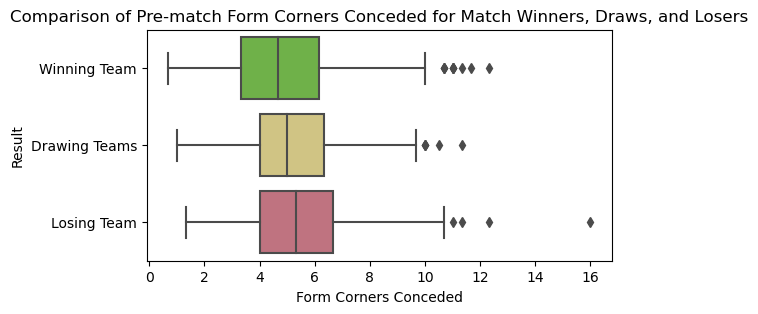

,count,mean,std,min,25%,50%,75%,max
Winning Team,567.0,4.870829,2.032021,0.67,3.33,4.67,6.165,12.33
Drawing Teams,346.0,5.114595,1.873054,1.00,4.00,5.00,6.330,11.33
Losing Team,567.0,5.432787,1.871462,1.33,4.00,5.33,6.670,16.00


In [40]:
compare_form_corners_c = compare_form(epl_df, 'Form_H_Corners_Conceded', 'Form_A_Corners_Conceded', 'Form Corners Conceded', 
                                  'Comparison of Pre-match Form Corners Conceded for Match Winners, Draws, and Losers')
compare_form_corners_c

In [41]:
x1 = test_percent(epl_df, 'Form_H_Corners', 'Form_A_Corners')
print(f'The team with the higher pre-match form corners received won {x1}% of matches')
x2 = test_percent(epl_df, 'Season_H_Corners', 'Season_A_Corners')
print(f'The team with the higher pre-match season corners received won {x2}% of matches')

percent_df = pd.concat([percent_df, pd.DataFrame({'Match Statistic': 'Corners Received', 'Form Win %': str(x1) + '%', 'Season Win %': str(x2) + '%'}, index=[0])], ignore_index=True)
percent_df

The team with the higher pre-match form corners received won 44.324% of matches
The team with the higher pre-match season corners received won 50.811% of matches


,Match Statistic,Form Win %,Season Win %
0,Goals Scored,40.0%,46.622%
1,Shots Taken,46.622%,50.811%
2,Shots On Target Taken,44.459%,49.73%
3,Corners Received,44.324%,50.811%


###  Fouls

In [42]:
total_fouls = get_season_totals(epl_df, 'H_Fouls', 'A_Fouls', 'Season_H_Fouls_Conceded', 'Season_H_Fouls_Received', 'Season_A_Fouls_Conceded', "Season_A_Fouls_Received", "Fouls_Conceded", "Fouls_Received", ["2022-05-22", "2023-05-28"])
total_fouls.to_csv('Fouls.csv', sep=',', index=False, mode='w')
total_fouls

,Team,S1_Fouls_Conceded,S1_Fouls_Received,S2_Fouls_Conceded,S2_Fouls_Received
0,Arsenal,363.0,376.0,373.0,457.0
1,Aston Villa,401.0,512.0,417.0,497.0
2,Bournemouth,X,X,391.0,375.0
3,Brentford,371.0,377.0,354.0,414.0
4,Brighton,393.0,372.0,426.0,426.0
5,Burnley,394.0,339.0,X,X
6,Chelsea,409.0,405.0,397.0,467.0
7,Crystal Palace,415.0,500.0,446.0,487.0
8,Everton,368.0,401.0,396.0,401.0
9,Fulham,X,X,411.0,419.0


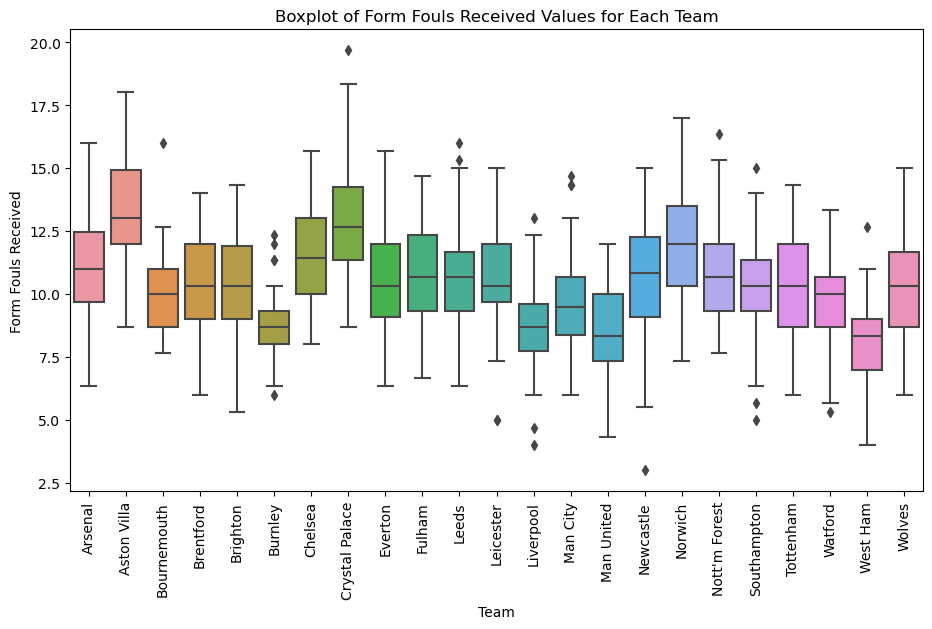

In [43]:
form_fouls_df = boxplot_team_form(epl_df, 'Form_H_Fouls_Received', 'Form_A_Fouls_Received', 
                                              'Form Fouls Received', 'Boxplot of Form Fouls Received Values for Each Team')

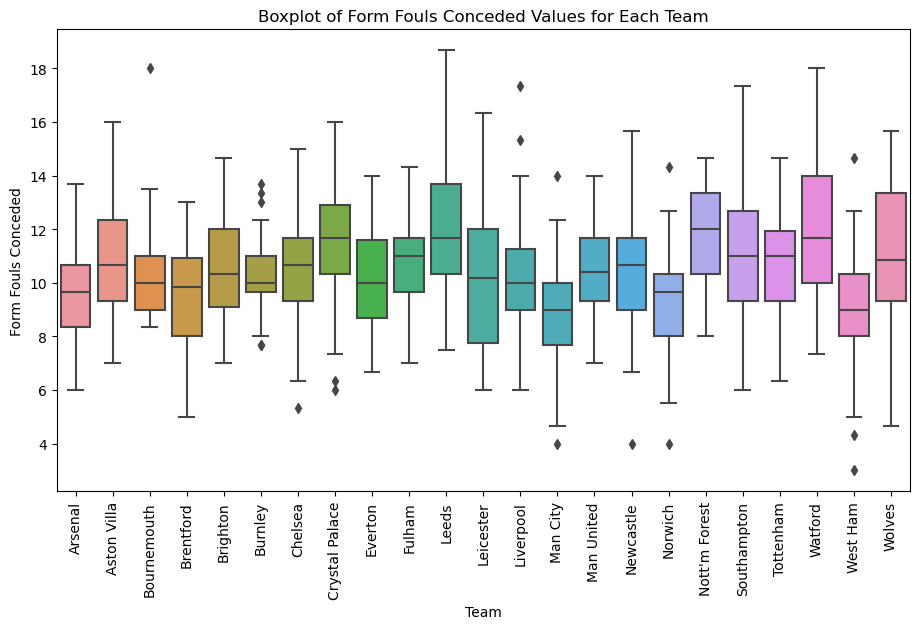

In [44]:
form_fouls_c_df = boxplot_team_form(epl_df, 'Form_H_Fouls_Conceded', 'Form_A_Fouls_Conceded', 
                                              'Form Fouls Conceded', 'Boxplot of Form Fouls Conceded Values for Each Team')

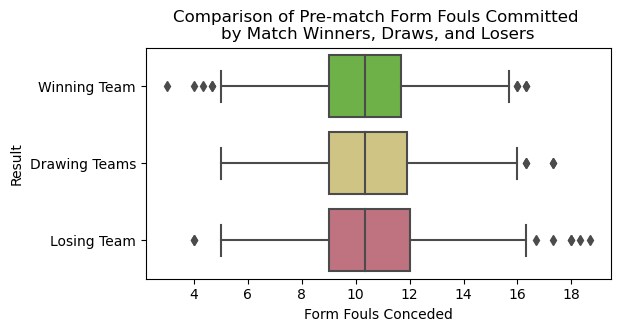

,count,mean,std,min,25%,50%,75%,max
Winning Team,567.0,10.307566,2.175805,3.0,9.0,10.33,11.6700,16.33
Drawing Teams,346.0,10.461763,2.177376,5.0,9.0,10.33,11.9175,17.33
Losing Team,567.0,10.586931,2.296198,4.0,9.0,10.33,12.0000,18.67


In [45]:
compare_form_fouls_c = compare_form(epl_df, 'Form_H_Fouls_Conceded', 'Form_A_Fouls_Conceded', 'Form Fouls Conceded', 
                                  'Comparison of Pre-match Form Fouls Committed \nby Match Winners, Draws, and Losers')
compare_form_fouls_c

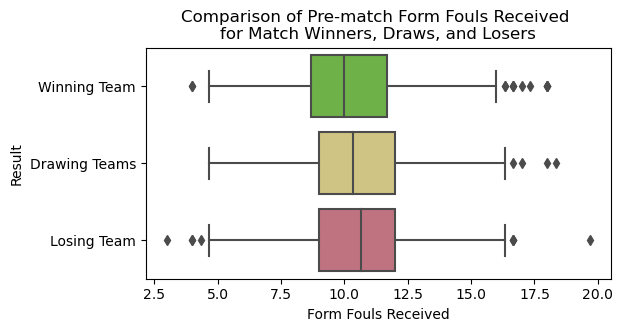

,count,mean,std,min,25%,50%,75%,max
Winning Team,567.0,10.232875,2.346369,4.00,8.67,10.00,11.67,18.00
Drawing Teams,346.0,10.518757,2.371450,4.67,9.00,10.33,12.00,18.33
Losing Team,567.0,10.626561,2.329906,3.00,9.00,10.67,12.00,19.67


In [46]:
compare_form_fouls = compare_form(epl_df, 'Form_H_Fouls_Received', 'Form_A_Fouls_Received', 'Form Fouls Received', 
                                  'Comparison of Pre-match Form Fouls Received \nfor Match Winners, Draws, and Losers')
compare_form_fouls

In [47]:
x1 = test_percent(epl_df, 'Form_H_Fouls_Received', 'Form_A_Fouls_Received')
print(f'The team with the higher pre-match form fouls received won {x1}% of matches')
x2 = test_percent(epl_df, 'Season_H_Fouls_Received', 'Season_A_Fouls_Received')
print(f'The team with the higher pre-match season fouls received won {x2}% of matches')

percent_df = pd.concat([percent_df, pd.DataFrame({'Match Statistic': 'Fouls Received', 'Form Win %': str(x1) + '%', 'Season Win %': str(x2) + '%'}, index=[0])], ignore_index=True)
percent_df

The team with the higher pre-match form fouls received won 31.757% of matches
The team with the higher pre-match season fouls received won 32.568% of matches


,Match Statistic,Form Win %,Season Win %
0,Goals Scored,40.0%,46.622%
1,Shots Taken,46.622%,50.811%
2,Shots On Target Taken,44.459%,49.73%
3,Corners Received,44.324%,50.811%
4,Fouls Received,31.757%,32.568%


###  Points

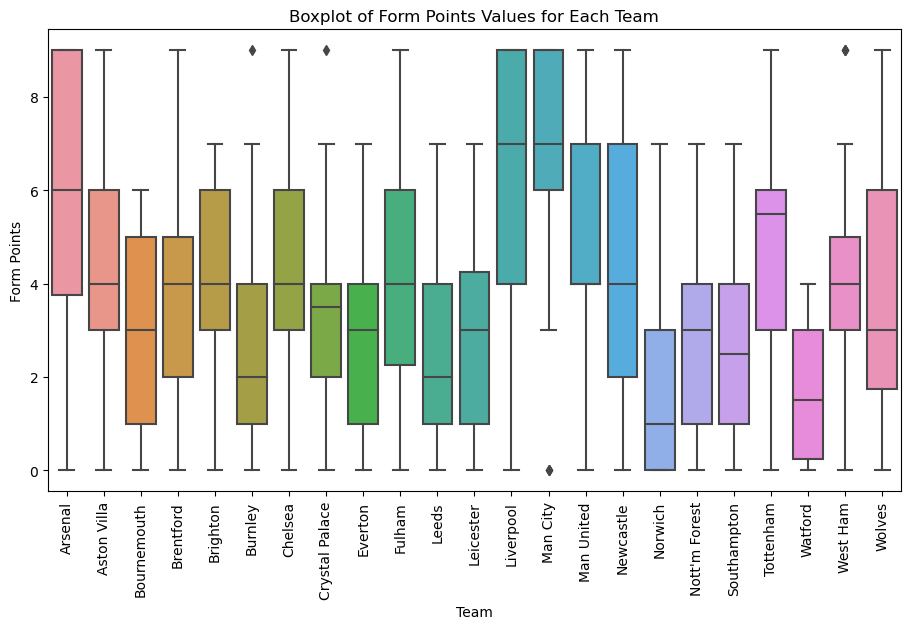

In [48]:
form_points_df = boxplot_team_form(epl_df, 'Form_H_Points', 'Form_A_Points', 
                                              'Form Points', 'Boxplot of Form Points Values for Each Team')

In [49]:
#form_points_df.groupby('Team')['Form Points'].describe()

form_points_s1 = boxplot_team_form(season1_df, 'Form_H_Points', 'Form_A_Points', 'Form Points', 'Boxplot of Form Points Values for Each Team', plot=False)
form_points_s2 = boxplot_team_form(season2_df, 'Form_H_Points', 'Form_A_Points', 'Form Points', 'Boxplot of Form Points Values for Each Team', plot=False)

avg_formpoints_df = pd.DataFrame({'Season 1': np.round(form_points_s1.groupby('Team')['Form Points'].describe()['mean'], 2), 'Season 2': np.round(form_points_s2.groupby('Team')['Form Points'].describe()['mean'], 2)})
avg_formpoints_df

,Season 1,Season 2
Team,,
Arsenal,5.21,6.39
Aston Villa,3.47,4.45
Bournemouth,NaN,3.08
Brentford,3.39,4.18
Brighton,3.66,4.76
Burnley,2.71,NaN
Chelsea,5.47,3.39
Crystal Palace,3.53,3.34
Everton,2.92,2.55


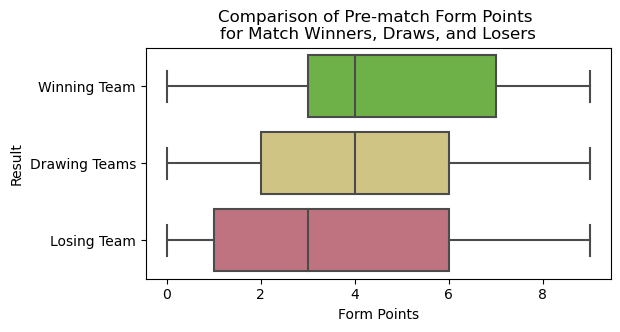

,count,mean,std,min,25%,50%,75%,max
Winning Team,585.0,4.425641,2.716961,0.0,3.0,4.0,7.0,9.0
Drawing Teams,350.0,3.905714,2.563737,0.0,2.0,4.0,6.0,9.0
Losing Team,585.0,3.478632,2.482122,0.0,1.0,3.0,6.0,9.0


In [50]:
compare_form_points = compare_form(epl_df, 'Form_H_Points', 'Form_A_Points', 'Form Points', 
                                  'Comparison of Pre-match Form Points \nfor Match Winners, Draws, and Losers')
compare_form_points

In [51]:
x1 = test_percent(epl_df, 'Form_H_Points', 'Form_A_Points')
print(f'The team with the higher pre-match form points won {x1}% of matches')
x2 = test_percent(epl_df, 'Season_H_Points', 'Season_A_Points')
print(f'The team with the higher pre-match season points won {x2}% of matches')

percent_df = pd.concat([percent_df, pd.DataFrame({'Match Statistic': 'Points', 'Form Win %': str(x1) + '%', 'Season Win %': str(x2) + '%'}, index=[0])], ignore_index=True)
percent_df

The team with the higher pre-match form points won 40.405% of matches
The team with the higher pre-match season points won 48.108% of matches


,Match Statistic,Form Win %,Season Win %
0,Goals Scored,40.0%,46.622%
1,Shots Taken,46.622%,50.811%
2,Shots On Target Taken,44.459%,49.73%
3,Corners Received,44.324%,50.811%
4,Fouls Received,31.757%,32.568%
5,Points,40.405%,48.108%


## Match Prediction Machine Learning Model

In [52]:
# Function to evaluate performance of a model
def evaluate_model(results, predictions, cm=False):
    f1_average = f1_score(results, predictions, average='weighted')
    f1_class = f1_score(results, predictions, average=None)
    acc = accuracy_score(results, predictions)
    
    data = {
        'Metric': ['F1 Score', 'F1 Score (Home)', 'F1 Score (Draw)', 'F1 Score (Away)', 'Accuracy'],
        'Value': [f1_average, f1_class[0], f1_class[1], f1_class[2], acc]
    }
    em_df = pd.DataFrame(data)
    display(em_df)
    
    if cm:       
        # Display confusion matrix
        results_cm = confusion_matrix(results, predictions)
        plt.figure(figsize=(2, 2))
        sns.heatmap(results_cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=result_map.keys(), yticklabels=result_map.keys())
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    
    return f1_average, f1_class, acc

### Data Preparations

In [53]:
# Convert NaN values to numeric values
ML_df = epl_df
ML_df.fillna(0, inplace=True)

# Convert team name to numeric values (Aston Villa = 1, ...)
ML_df['HomeTeam'] = ML_df['Home_Team'].astype('category').cat.codes
ML_df['AwayTeam'] = ML_df['Away_Team'].astype('category').cat.codes

# Convert result into numeric values
result_map = {'H': 0, 'D': 1, 'A': 2}
ML_df['Result'] = ML_df['FT_Result'].map(result_map)
ML_df

,Date,Time,Home_Team,Away_Team,FT_HomeGoals,FT_AwayGoals,FT_Result,HT_HomeGoals,HT_AwayGoals,HT_Result,...,Form_H_Fouls_Received,Form_A_Fouls_Received,Form_A_Fouls_Conceded,Season_H_Points,Season_A_Points,Form_H_Points,Form_A_Points,HomeTeam,AwayTeam,Result
0,2021-08-13,20:00,Brentford,Arsenal,2,0,H,1,0,H,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,3,0,0
1,2021-08-14,12:30,Man United,Leeds,5,1,H,1,0,H,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,14,10,0
2,2021-08-14,15:00,Burnley,Brighton,1,2,A,1,0,H,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,5,4,2
3,2021-08-14,15:00,Chelsea,Crystal Palace,3,0,H,2,0,H,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,6,7,0
4,2021-08-14,15:00,Everton,Southampton,3,1,H,0,1,A,...,0.00,0.00,0.00,0.0,0.0,0.0,0.0,8,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2023-05-28,16:30,Everton,Bournemouth,1,0,H,0,0,D,...,11.00,7.67,9.00,33.0,39.0,4.0,0.0,8,2,0
756,2023-05-28,16:30,Leeds,Tottenham,1,4,A,0,1,A,...,7.67,10.67,13.33,31.0,57.0,1.0,3.0,10,19,2
757,2023-05-28,16:30,Leicester,West Ham,2,1,H,1,0,H,...,13.00,8.33,5.00,31.0,40.0,1.0,6.0,11,21,0
758,2023-05-28,16:30,Man United,Fulham,2,1,H,1,1,D,...,7.00,14.67,12.67,72.0,52.0,9.0,7.0,14,9,0


In [54]:
# Calculate the split points based on percentiles
train_split = ML_df['Date'].quantile(0.7)
val_split = ML_df['Date'].quantile(0.85)

# Split the data into training, validation, and testing sets
train_data = ML_df[ML_df['Date'] < train_split]
val_data = ML_df[(ML_df['Date'] >= train_split) & (ML_df['Date'] < val_split)]
test_data = ML_df[ML_df['Date'] >= val_split]

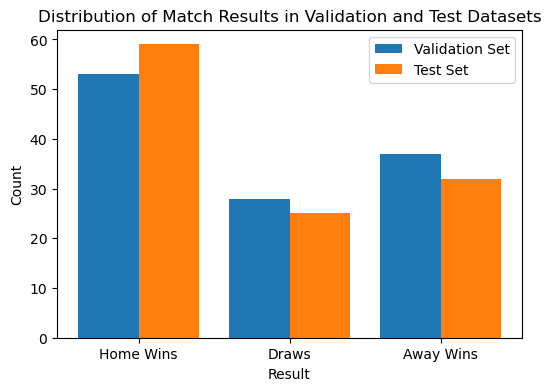

In [55]:
# Calculate the count of values in the 'Result' column for each dataframe
val_counts = val_data['Result'].value_counts().sort_index()
test_counts = test_data['Result'].value_counts().sort_index()

# Bar chart
fig, ax = plt.subplots(figsize=(6, 4))
rects1 = ax.bar(np.arange(3) - 0.2, val_counts.values, 0.4, label='Validation Set')
rects2 = ax.bar(np.arange(3) + 0.2, test_counts.values, 0.4, label='Test Set')
ax.set_xlabel('Result')
ax.set_ylabel('Count')
ax.set_title('Distribution of Match Results in Validation and Test Datasets')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Home Wins', 'Draws', 'Away Wins'])
ax.legend()
plt.show()

### Model 1: Random Forest

#### Feature Selection

In [56]:
# Chosen features for model 1
model_rf_predictors = ['HomeTeam', 'AwayTeam', 
                        'Form_H_Shots', 'Form_A_Shots', 
                        'Season_H_Points', 'Season_A_Points', 
                        'Season_H_Corners', 'Season_A_Corners']

#### Model Training

In [57]:
# Initialize model with chosen hyperparameters
model_rf1 = RandomForestClassifier(n_estimators=100, min_samples_split=2, random_state=rndseed)

# Train model to training data
model_rf1.fit(train_data[model_rf_predictors], train_data['Result'])

# Make predictions using validation data
model_rf1_preds = model_rf1.predict(val_data[model_rf_predictors])

#### Model Validation

In [58]:
rf_f1avg, rf_f1class, rf_acc = evaluate_model(val_data['Result'], model_rf1_preds)

,Metric,Value
0,F1 Score,0.501380
1,F1 Score (Home),0.690265
2,F1 Score (Draw),0.051282
3,F1 Score (Away),0.571429
4,Accuracy,0.542373


#### Model Optimization and Final Evaluation

,Metric,Value
0,F1 Score,0.529533
1,F1 Score (Home),0.716418
2,F1 Score (Draw),0.071429
3,F1 Score (Away),0.542857
4,Accuracy,0.586207


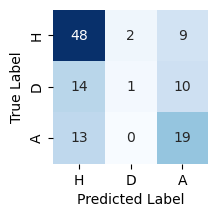

In [59]:
# Initialize model with chosen hyperparameters
model_rf2 = RandomForestClassifier(n_estimators=200, min_samples_split=10, random_state=111)

# Train model to training data
model_rf2.fit(train_data[model_rf_predictors], train_data['Result'])

# Make predictions using test data
model_rf2_preds = model_rf2.predict(test_data[model_rf_predictors])

# Evaluate performance of model
rf_f1avg2, rf_f1class2, rf_acc2 = evaluate_model(test_data['Result'], model_rf2_preds, cm=True)

In [60]:
# Obtain feature importances
model_rf_feature_importances = model_rf2.feature_importances_
importance_df = pd.DataFrame({'Feature': model_rf_predictors, 'Importance': model_rf_feature_importances})
importance_df

,Feature,Importance
0,HomeTeam,0.114076
1,AwayTeam,0.098830
2,Form_H_Shots,0.129697
3,Form_A_Shots,0.150864
4,Season_H_Points,0.129013
5,Season_A_Points,0.123083
6,Season_H_Corners,0.124596
7,Season_A_Corners,0.129839


### Model 2: Gaussian Naive Bayes

#### Feature Selection

In [61]:
# Chosen features for model 2
model_nb_predictors = ['HomeTeam', 'AwayTeam', 
                       'Form_H_Shots_Conceded', 'Form_A_Shots_Conceded', 
                       'Season_H_Points', 'Season_A_Points', 
                       'Season_H_Corners_Conceded', 'Season_A_Corners_Conceded']

#### Model Training

In [62]:
# Initialize model
model_nb1 = GaussianNB()

# Train model to training data
model_nb1.fit(train_data[model_nb_predictors], train_data['Result'])

# Make predictions using validation data
model_nb1_preds = model_nb1.predict(val_data[model_nb_predictors])

#### Model Validation

In [63]:
# Evaluate performance of model
nb_f1avg, nb_f1class, nb_acc = evaluate_model(val_data['Result'], model_nb1_preds)

,Metric,Value
0,F1 Score,0.473810
1,F1 Score (Home),0.692913
2,F1 Score (Draw),0.000000
3,F1 Score (Away),0.518519
4,Accuracy,0.550847


#### Model Optimization and Final Evaluation

,Metric,Value
0,F1 Score,0.511890
1,F1 Score (Home),0.698413
2,F1 Score (Draw),0.000000
3,F1 Score (Away),0.567901
4,Accuracy,0.577586


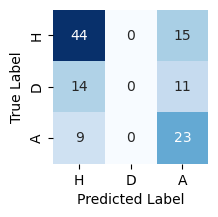

In [64]:
# Create a Naive Bayes classifier
model_nb2 = GaussianNB()

# Train the model
model_nb2.fit(train_data[model_nb_predictors], train_data['Result'])

# Make predictions on test data
model_nb2_preds = model_nb2.predict(test_data[model_nb_predictors])

# Evaluate performance of model
nb_f1avg2, nb_f1class2, nb_acc2 = evaluate_model(test_data['Result'], model_nb2_preds, cm=True)

### Model 3: Support Vector Machine

#### Feature Selection

In [65]:
# Chosen features for model 3
model_svm_predictors = ['HomeTeam', 'AwayTeam', 
                        'Form_H_Shots_Conceded', 'Form_A_Shots_Conceded', 
                        'Form_FT_HomeGoals_Conceded', 'Form_FT_AwayGoals_Conceded', 
                        'Season_H_Corners_Conceded', 'Season_A_Corners_Conceded']

#### Model Training

In [66]:
# Initialize model with chosen hyperparameters
model_svm1 = SVC(C=1.0, class_weight={0: 1, 1: 2, 2: 1})
    
# Train model to training data
model_svm1.fit(train_data[model_svm_predictors], train_data['Result']) 
    
# Make predictions using validation data
model_svm1_preds = model_svm1.predict(val_data[model_svm_predictors]) 

#### Model Validation

In [67]:
# Evaluate performance of model
svm_f1avg, svm_f1class, svm_acc = evaluate_model(val_data['Result'], model_svm1_preds)

,Metric,Value
0,F1 Score,0.420698
1,F1 Score (Home),0.571429
2,F1 Score (Draw),0.404040
3,F1 Score (Away),0.217391
4,Accuracy,0.432203


#### Model Optimization and Final Evaluation


,Metric,Value
0,F1 Score,0.563458
1,F1 Score (Home),0.655462
2,F1 Score (Draw),0.410256
3,F1 Score (Away),0.513514
4,Accuracy,0.568966


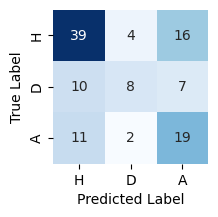

In [68]:
# Initialize model with chosen hyperparameters
model_svm2 = SVC(C=10.0, class_weight={0: 1, 1: 2.25, 2: 1.25})

# Train the classifier on the training set
model_svm2.fit(train_data[model_svm_predictors], train_data['Result']) 
   
# Make predictions on the test set
model_svm2_preds = model_svm2.predict(test_data[model_svm_predictors])

# Evaluate performance of model
svm_f1avg2, svm_f1class2, svm_acc2 = evaluate_model(test_data['Result'], model_svm2_preds, cm=True)

### Model 4: K-Nearest Neighbours

#### Feature Selection

In [69]:
# Chosen features for model 4
model_knn_predictors = ['HomeTeam', 'AwayTeam', 
                        'Form_H_Shots_Conceded', 'Form_A_Shots_Conceded', 
                        'Form_FT_HomeGoals_Conceded', 'Form_FT_AwayGoals_Conceded', 
                        'Season_H_Corners_Conceded', 'Season_A_Corners_Conceded']

#### Model Training

In [70]:
# Create a KNN classifier
model_knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
model_knn.fit(train_data[model_knn_predictors], train_data['Result'])

# Make predictions
model_knn_preds = model_knn.predict(val_data[model_knn_predictors])

#### Model Validation

In [71]:
# Evaluate performance of model
knn_f1avg, knn_f1class, knn_acc = evaluate_model(val_data['Result'], model_knn_preds)

,Metric,Value
0,F1 Score,0.466066
1,F1 Score (Home),0.621849
2,F1 Score (Draw),0.204082
3,F1 Score (Away),0.441176
4,Accuracy,0.483051


#### Model Optimization and Final Evaluation

,Metric,Value
0,F1 Score,0.550779
1,F1 Score (Home),0.735294
2,F1 Score (Draw),0.297872
3,F1 Score (Away),0.408163
4,Accuracy,0.577586


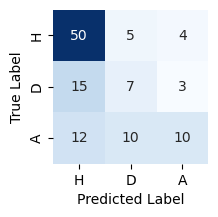

In [72]:
# Create a KNN classifier
model_knn2 = KNeighborsClassifier(n_neighbors=2)

# Train the model
model_knn2.fit(train_data[model_knn_predictors], train_data['Result'])

# Make predictions
model_knn2_preds = model_knn2.predict(test_data[model_knn_predictors])

# Evaluate performance of model
knn_f1avg2, knn_f1class2, knn_acc2 = evaluate_model(test_data['Result'], model_knn2_preds, cm=True)

### Results

In [73]:
# Dataframe of model results
r = {'Model': ['Random Forest', 'Naive Bayes', 'Support Vector Machine', 'K Nearest Neighbours'],
     'Overall Accuracy': [rf_acc2, nb_acc2, svm_acc2, knn_acc2],
     'F1 Score Avg': [rf_f1avg2, nb_f1avg2, svm_f1avg2, knn_f1avg2], 
     'F1 Score Home': [rf_f1class2[0], nb_f1class2[0], svm_f1class2[0], knn_f1class2[0]], 
     'F1 Score Draw': [rf_f1class2[1], nb_f1class2[1], svm_f1class2[1], knn_f1class2[1]], 
     'F1 Score Away': [rf_f1class2[2], nb_f1class2[2], svm_f1class2[2], knn_f1class2[2]]}
model_results = pd.DataFrame(r)
model_results

,Model,Overall Accuracy,F1 Score Avg,F1 Score Home,F1 Score Draw,F1 Score Away
0,Random Forest,0.586207,0.529533,0.716418,0.071429,0.542857
1,Naive Bayes,0.577586,0.511890,0.698413,0.000000,0.567901
2,Support Vector Machine,0.568966,0.563458,0.655462,0.410256,0.513514
3,K Nearest Neighbours,0.577586,0.550779,0.735294,0.297872,0.408163


#### Combining Predictions

In [74]:
t = {
    'Date': test_data['Date'],
    'Home_Team': test_data['Home_Team'],
    'Away_Team': test_data['Away_Team'],
    'SVM_Pred': model_svm2_preds,
    'RF_Pred': model_rf2_preds,
    'KNN_Pred': model_knn2_preds
}

# Dataframe of combined results
allpreds = pd.DataFrame(t)

# Combine predictions into a single string for each row
allpreds['E_Preds'] = allpreds['SVM_Pred'].astype(str) + allpreds['RF_Pred'].astype(str) + allpreds['KNN_Pred'].astype(str)

# Find the most common character in each row's combined predictions using Counter
allpreds['Combined_Pred'] = allpreds['E_Preds'].apply(lambda x: int(Counter(x).most_common(1)[0][0]))
allpreds

,Date,Home_Team,Away_Team,SVM_Pred,RF_Pred,KNN_Pred,E_Preds,Combined_Pred
644,2023-03-18,Aston Villa,Bournemouth,0,0,0,000,0
645,2023-03-18,Brentford,Leicester,1,0,1,101,1
646,2023-03-18,Southampton,Tottenham,2,2,0,220,2
647,2023-03-18,Wolves,Leeds,2,0,1,201,2
648,2023-03-18,Chelsea,Everton,0,0,0,000,0
...,...,...,...,...,...,...,...,...
755,2023-05-28,Everton,Bournemouth,2,0,0,200,0
756,2023-05-28,Leeds,Tottenham,0,0,0,000,0
757,2023-05-28,Leicester,West Ham,2,1,0,210,2
758,2023-05-28,Man United,Fulham,0,0,0,000,0


,Metric,Value
0,F1 Score,0.569252
1,F1 Score (Home),0.706767
2,F1 Score (Draw),0.258065
3,F1 Score (Away),0.558824
4,Accuracy,0.603448


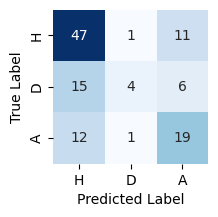

In [75]:
# Evaluate performance of model
c_f1avg, c_f1class, c_acc = evaluate_model(test_data['Result'], allpreds['Combined_Pred'], cm=True)

In [76]:
# Add combined results to dataframe
model_results = pd.concat([model_results, pd.DataFrame({'Model': 'Combined: SVM / RF / KNN', 'Overall Accuracy': c_acc, 'F1 Score Avg': c_f1avg, 'F1 Score Home': c_f1class[0], 'F1 Score Draw': c_f1class[1], 'F1 Score Away': c_f1class[2]}, index=[0])], ignore_index=True)
model_results

,Model,Overall Accuracy,F1 Score Avg,F1 Score Home,F1 Score Draw,F1 Score Away
0,Random Forest,0.586207,0.529533,0.716418,0.071429,0.542857
1,Naive Bayes,0.577586,0.511890,0.698413,0.000000,0.567901
2,Support Vector Machine,0.568966,0.563458,0.655462,0.410256,0.513514
3,K Nearest Neighbours,0.577586,0.550779,0.735294,0.297872,0.408163
4,Combined: SVM / RF / KNN,0.603448,0.569252,0.706767,0.258065,0.558824


#### Comparison vs Bookmakers

In [77]:
bookmaker_df

,Date,Time,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,B365_Pred,WHH,WHD,WHA,WH_Pred
0,2021-08-13,20:00,Brentford,Arsenal,H,4.00,3.40,1.95,A,4.00,3.40,1.90,A
1,2021-08-14,12:30,Man United,Leeds,H,1.53,4.50,5.75,H,1.52,4.33,5.80,H
2,2021-08-14,15:00,Burnley,Brighton,A,3.10,3.10,2.45,A,3.20,3.00,2.45,A
3,2021-08-14,15:00,Chelsea,Crystal Palace,H,1.25,5.75,13.00,H,1.25,5.50,13.00,H
4,2021-08-14,15:00,Everton,Southampton,H,1.90,3.50,4.00,H,1.95,3.40,4.00,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2023-05-28,16:30,Everton,Bournemouth,H,1.50,4.50,6.50,H,1.36,4.20,6.50,H
756,2023-05-28,16:30,Leeds,Tottenham,A,2.75,3.80,2.30,A,2.60,3.50,2.20,A
757,2023-05-28,16:30,Leicester,West Ham,H,1.91,3.80,3.60,H,1.85,3.60,3.30,H
758,2023-05-28,16:30,Man United,Fulham,H,1.50,4.33,6.00,H,1.44,4.20,5.50,H


In [78]:
# Convert results and predictions into numeric values
bookmaker_df['FTR'] = bookmaker_df['FTR'].map(result_map)
bookmaker_df['B365_Pred'] = bookmaker_df['B365_Pred'].map(result_map)
bookmaker_df['WH_Pred'] = bookmaker_df['WH_Pred'].map(result_map)

,Date,Time,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,B365_Pred,WHH,WHD,WHA,WH_Pred
0,2021-08-13,20:00,Brentford,Arsenal,0,4.00,3.40,1.95,2,4.00,3.40,1.90,2
1,2021-08-14,12:30,Man United,Leeds,0,1.53,4.50,5.75,0,1.52,4.33,5.80,0
2,2021-08-14,15:00,Burnley,Brighton,2,3.10,3.10,2.45,2,3.20,3.00,2.45,2
3,2021-08-14,15:00,Chelsea,Crystal Palace,0,1.25,5.75,13.00,0,1.25,5.50,13.00,0
4,2021-08-14,15:00,Everton,Southampton,0,1.90,3.50,4.00,0,1.95,3.40,4.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,2023-05-28,16:30,Everton,Bournemouth,0,1.50,4.50,6.50,0,1.36,4.20,6.50,0
756,2023-05-28,16:30,Leeds,Tottenham,2,2.75,3.80,2.30,2,2.60,3.50,2.20,2
757,2023-05-28,16:30,Leicester,West Ham,0,1.91,3.80,3.60,0,1.85,3.60,3.30,0
758,2023-05-28,16:30,Man United,Fulham,0,1.50,4.33,6.00,0,1.44,4.20,5.50,0


In [80]:
bookmaker_val_data = bookmaker_df[(bookmaker_df['Date'] >= train_split) & (bookmaker_df['Date'] < val_split)]
bookmaker_test_data = bookmaker_df[bookmaker_df['Date'] >= val_split]

# Check number of different predictions in test dataset.
differences = (bookmaker_test_data['B365_Pred'] != bookmaker_test_data['WH_Pred']).sum()
print(f"There are {differences} different predictions between B365 and WH.")

There are 0 different predictions between B365 and WH.


#### William Hill Predictions

,Metric,Value
0,F1 Score,0.519865
1,F1 Score (Home),0.739130
2,F1 Score (Draw),0.000000
3,F1 Score (Away),0.521739
4,Accuracy,0.594828


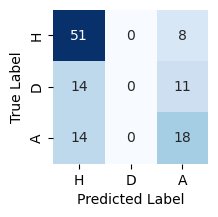

In [81]:
# Evaluate performance of model
wh_f1avg, wh_f1class, wh_acc = evaluate_model(bookmaker_test_data['FTR'], bookmaker_test_data['WH_Pred'], cm=True)

#### Results Comparison

In [82]:
# Add WH results to df
model_results = pd.concat([model_results, pd.DataFrame({'Model': ['William Hill Predictions'], 'Overall Accuracy': [wh_acc], 'F1 Score Avg': [wh_f1avg], 'F1 Score Home': [wh_f1class[0]], 'F1 Score Draw': [wh_f1class[1]], 'F1 Score Away': [wh_f1class[2]]})], ignore_index=True)
model_results

,Model,Overall Accuracy,F1 Score Avg,F1 Score Home,F1 Score Draw,F1 Score Away
0,Random Forest,0.586207,0.529533,0.716418,0.071429,0.542857
1,Naive Bayes,0.577586,0.511890,0.698413,0.000000,0.567901
2,Support Vector Machine,0.568966,0.563458,0.655462,0.410256,0.513514
3,K Nearest Neighbours,0.577586,0.550779,0.735294,0.297872,0.408163
4,Combined: SVM / RF / KNN,0.603448,0.569252,0.706767,0.258065,0.558824
5,William Hill Predictions,0.594828,0.519865,0.739130,0.000000,0.521739


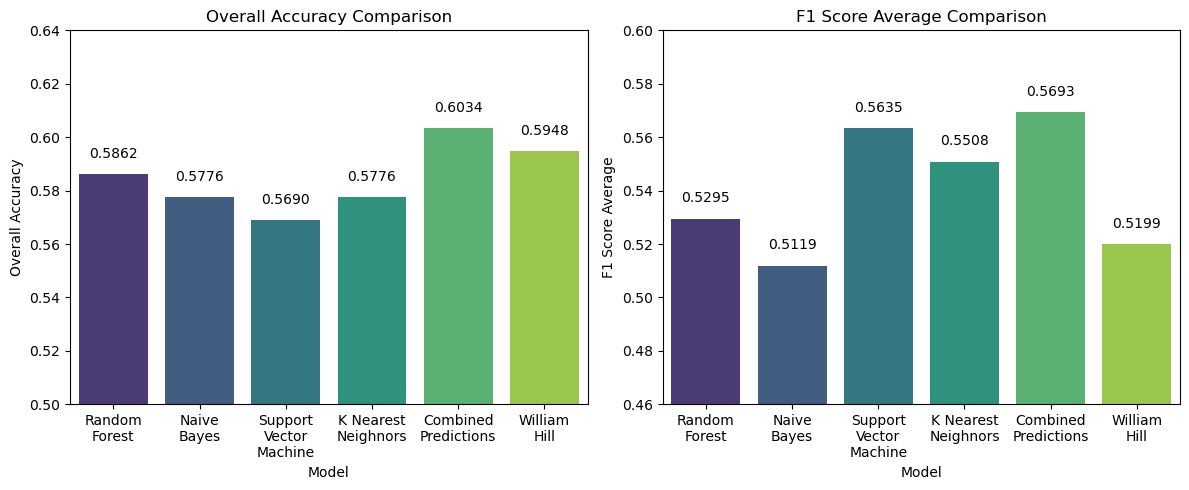

In [93]:
# Create the subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
models = ['Random\nForest', 'Naive\nBayes', 'Support\nVector\nMachine', 'K Nearest\nNeighnors', 'Combined\nPredictions', 'William\nHill']

# Plot 1: Overall Accuracy
sns.barplot(x=models, y=model_results['Overall Accuracy'], palette="viridis", ax=axes[0])
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Overall Accuracy')
axes[0].set_title('Overall Accuracy Comparison')
axes[0].set_ylim(0.5, 0.64)
for index, value in enumerate(model_results['Overall Accuracy']):
    axes[0].text(index, value + 0.005, f"{value:.4f}", ha='center', va='bottom')

# Plot 2: F1 Score Average
sns.barplot(x=models, y=model_results['F1 Score Avg'], palette="viridis", ax=axes[1])
axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1 Score Average')
axes[1].set_title('F1 Score Average Comparison')
axes[1].set_ylim(0.46, 0.6)
for index, value in enumerate(model_results['F1 Score Avg']):
    axes[1].text(index, value + 0.005, f"{value:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()